In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from imblearn.over_sampling import SMOTE
import seaborn as sns

In [ ]:
def parse_data(data: pd.DataFrame):
    """
    Reads input dataframe then return arrays of images and labels
    """
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

In [ ]:
def show_img(images: np.ndarray, labels: np.ndarray):
    """
    Visualize images and labels respectively
    """
    _, axarr=plt.subplots(nrows=2, ncols=5, figsize=(18, 9))
    axarr=axarr.flatten()
    for idx, label in enumerate(labels[:10]):
        axarr[idx].imshow(images[idx], cmap='gray')
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])
        axarr[idx].set_title("Label:{}".format(label))

In [ ]:
## load dataset here
df = pd.read_csv("/content/drive/MyDrive/mini project/icml_face_data.csv")
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [ ]:
df.emotion.value_counts()

,count
emotion,
3,8989
6,6198
4,6077
2,5121
0,4953
5,4002
1,547


The ```emotion``` column contains a numeric code ranging from 0 to 6, inclusive, for the emotion expressed by the image. The "pixels" column contains a string surrounded in quotes for each image.

In [ ]:
## parsing data here
images, labels = parse_data(df)
images.shape, labels.shape

((35887, 48, 48), (35887,))

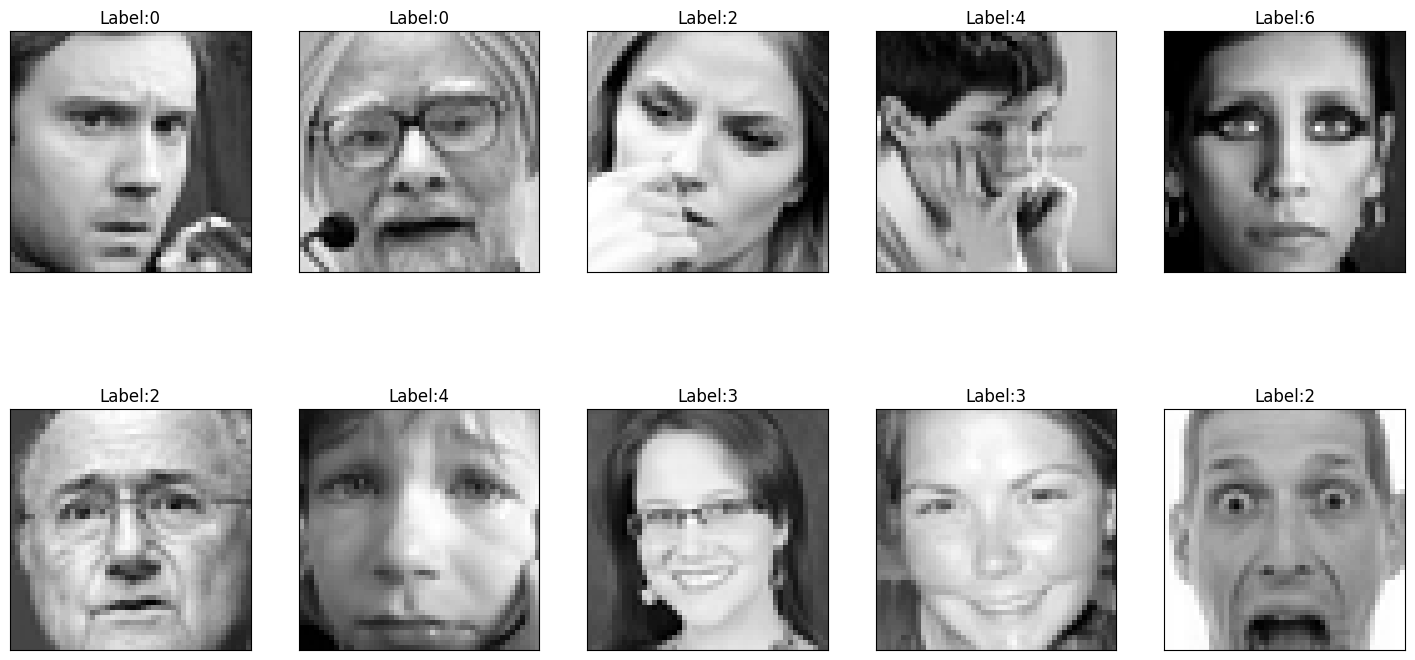

In [ ]:
## showing images here
show_img(images, labels)

Question 1: Can you visualize the data projected onto two principal components? (2 points)

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Facial expression recognition
Facial expression recognition was performed on the face images from the Facial Expression Recognition Challenge (FER2013) dataset.

One motivation for representation learning is that learning algorithms can design features more effectively and efficiently than humans can. However, this challenge does not explicitly require entries to use representation learning. The dataset, assembled from the internet, is designed for facial expression classification.

The data consists of grayscale images of faces, each measuring 48x48 pixels. The faces have been automatically aligned to be roughly centered and occupy a similar area within each image. The task is to categorize each face based on the emotion expressed, assigning it to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The dataset contains a total of 35,887 examples.

## 1. Prerequisite


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from imblearn.over_sampling import SMOTE
import seaborn as sns

from skimage.transform import rotate, warp, AffineTransform
from skimage.util import random_noise
from skimage.exposure import adjust_gamma

import cv2
import random

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

import optuna
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
import xgboost as xgb


In [ ]:
def parse_data(data: pd.DataFrame):
    """
    Reads input dataframe then return arrays of images and labels
    """
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

In [ ]:
def show_img(images: np.ndarray, labels: np.ndarray):
    """
    Visualize images and labels respectively
    """
    _, axarr=plt.subplots(nrows=2, ncols=5, figsize=(18, 9))
    axarr=axarr.flatten()
    for idx, label in enumerate(labels[:10]):
        axarr[idx].imshow(images[idx], cmap='gray')
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])
        axarr[idx].set_title("Label:{}".format(label))

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/mini project/icml_face_data.csv")
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [ ]:
df.emotion.value_counts()

,count
emotion,
3,8989
6,6198
4,6077
2,5121
0,4953
5,4002
1,547


The ```emotion``` column contains a numeric code ranging from 0 to 6, inclusive, for the emotion expressed by the image. The "pixels" column contains a string surrounded in quotes for each image.

In [ ]:

images, labels = parse_data(df)
images.shape, labels.shape

((35887, 48, 48), (35887,))

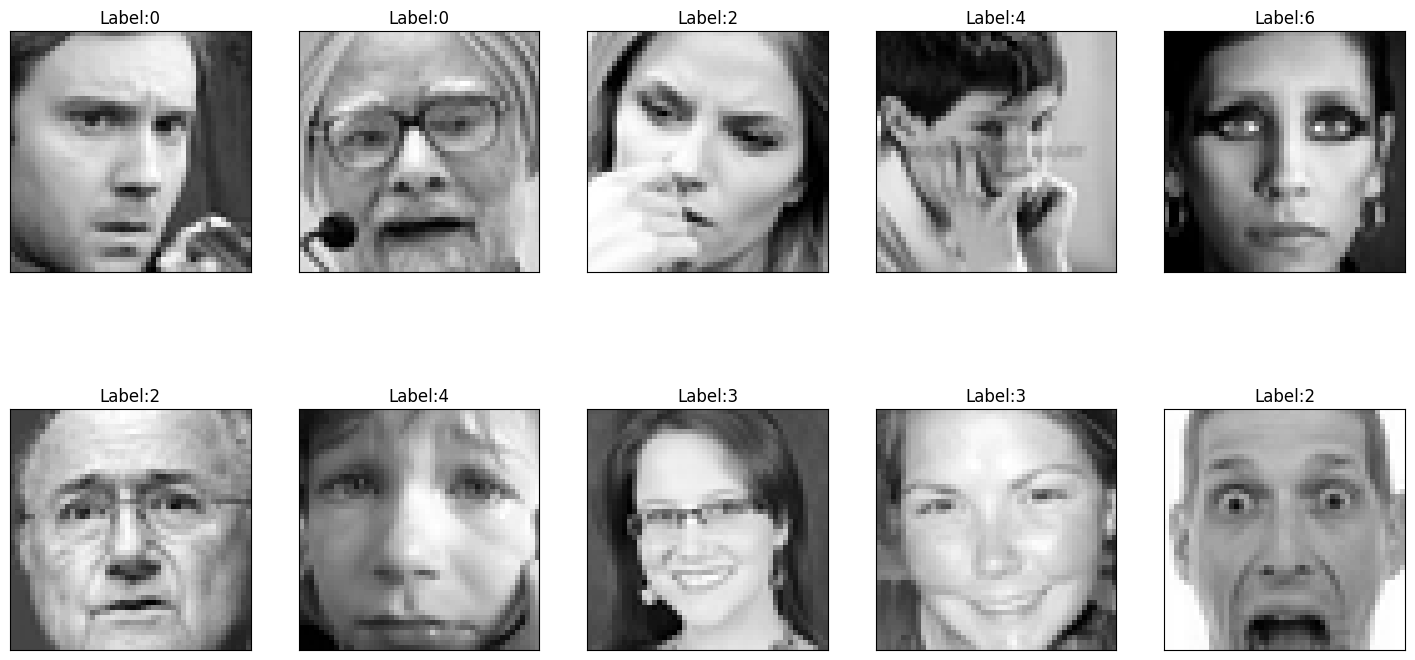

In [ ]:
show_img(images, labels)

Data augument

In [ ]:
def apply_augmentations(image):
    augmented_images = []
    augmented_images.append(image)
    flipped = cv2.flip(image, 1)  # Lật ngang
    augmented_images.append(flipped)

    angle = random.randint(-15, 15)
    h, w = image.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1)
    rotated = cv2.warpAffine(image, M, (w, h))
    augmented_images.append(rotated)

    bright = cv2.convertScaleAbs(image, alpha=1.2, beta=30)
    augmented_images.append(bright)

    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    augmented_images.append(blurred)



    return augmented_images

aug_images = []
aug_labels = []

for idx,image in enumerate(images):
    augmented  = apply_augmentations(image)
    aug_images.extend(augmented)  # Thêm trực tiếp ảnh vào list
    aug_labels.extend([labels[idx]] * len(augmented))  # Nhân label lên số lượng ảnh augment


aug_images = np.array(aug_images)
aug_labels = np.array(aug_labels)


## 2. Feature Engineering







PCA

In [ ]:
def convert_image2D(images):
  print("Hình dạng ban đầu của images:", images.shape)

  if images.ndim == 3:
      num_samples, height, width = images.shape
      images = images.reshape(num_samples, height * width)

  elif images.ndim == 2:
      raise
  else:
      raise ValueError("The images array must be 2-dimensional or 3-dimensional")
  return images

aug_images = convert_image2D(aug_images)
print("Hình dạng sau khi làm phẳng của images:", aug_images.shape)


Hình dạng ban đầu của images: (179435, 48, 48)
Hình dạng sau khi làm phẳng của images: (179435, 2304)


In [ ]:
pca=PCA(n_components=2)
principal_components = pca.fit_transform(aug_images)

In [ ]:
images_pca=pca.transform(aug_images) ## modify images' array to the appropriate shape
print(images_pca.shape)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(principal_components[:, 0], principal_components[:, 1], c=aug_labels, cmap='viridis')
plt.colorbar(scatter)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Face Data')
plt.show()

Question 2: How to determine the optimal number of principal components using ```pca.explained_variance_```? Explain your selection process. (2 points)

In [ ]:
pca = PCA()
pca.fit(aug_images)

explained_variance = pca.explained_variance_ratio_

cumulative_explained_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', label='Explained Variance')
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--', label='Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Variance Explained')
plt.title('Scree Plot')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
threshold = .85
optimal_pcs = np.argmax(cumulative_explained_variance >= threshold) + 1
print("Optimal number of principal components:", optimal_pcs)

Wavelet transform

## 3. Image Classification

In [ ]:
scaler = StandardScaler()
images_scaled = scaler.fit_transform(aug_images)

pca = PCA(n_components=optimal_pcs, svd_solver='full')
image_pca = pca.fit_transform(images_scaled)



X_train, X_test, y_train, y_test = train_test_split(image_pca, aug_labels, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)



#3.1 Hyperparameter Optimization with Optuna

In [ ]:



def objective_ExtraTrees(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 2, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)

    model = ExtraTreesClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    score = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring="accuracy").mean()
    return score

In [ ]:
study_ExtraTrees = optuna.create_study(direction="maximize")
study_ExtraTrees.optimize(objective_ExtraTrees, n_trials=50)

print("Best parameters:", study_ExtraTrees.best_params)

In [ ]:
import optuna
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score


def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 2, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)

    model = ExtraTreesClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    score = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring="accuracy").mean()
    return score

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best parameters:", study.best_params)

[I 2025-03-04 23:58:45,862] A new study created in memory with name: no-name-18548ea0-60ab-47d1-bc57-496a93e74b15
[I 2025-03-05 00:02:41,218] Trial 0 finished with value: 0.7873178302597749 and parameters: {'n_estimators': 214, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.7873178302597749.
[I 2025-03-05 00:02:52,199] Trial 1 finished with value: 0.2945702501877526 and parameters: {'n_estimators': 52, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.7873178302597749.
[I 2025-03-05 00:07:04,186] Trial 2 finished with value: 0.7046091509008783 and parameters: {'n_estimators': 263, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.7873178302597749.
[I 2025-03-05 00:08:58,095] Trial 3 finished with value: 0.375043076093296 and parameters: {'n_estimators': 245, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.

Best parameters: {'n_estimators': 269, 'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 2}


In [ ]:
def objective_xgb(trial):
    params = {
        "tree_method": "gpu_hist",
        "predictor": "gpu_predictor",
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "lambda": trial.suggest_float("lambda", 0, 5),
        "alpha": trial.suggest_float("alpha", 0, 5),
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train_resampled, y_train_resampled)

    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    return acc

study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_xgb, n_trials=50)

print("Best parameters:", study_xgb.best_params)
print("Best accuracy:", study_xgb.best_value)


[I 2025-03-05 09:01:12,574] A new study created in memory with name: no-name-e855a26b-a238-4e07-bf11-945a67dcfd05
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:01:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:01:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:01:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2025-03

Best parameters: {'n_estimators': 1000, 'max_depth': 12, 'learning_rate': 0.16682579393030028, 'subsample': 0.5780919713317749, 'colsample_bytree': 0.7633356080848968, 'gamma': 0.010996364334860145, 'lambda': 1.4859676166082776, 'alpha': 0.7692098872422231}
Best accuracy: 0.8097082508986541


# 3.2 Evaluate models

In [ ]:
from sklearn.metrics import(
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)
def evaluate_model(model, testX, testY):
    predictions = model.predict(testX)
    accuracy = accuracy_score(testY, predictions)
    precision = precision_score(testY, predictions, average='macro')
    recall = recall_score(testY, predictions, average='macro')
    f1 = f1_score(testY, predictions, average='macro')

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")

    print("\nClassification Report:")
    print(classification_report(testY, predictions))

In [ ]:
param = {'n_estimators': 1000, 'max_depth': 12, 'learning_rate': 0.16682579393030028, 'subsample': 0.5780919713317749, 'colsample_bytree': 0.7633356080848968, 'gamma': 0.010996364334860145, 'lambda': 1.4859676166082776, 'alpha': 0.7692098872422231}
model_xgb = xb.XGBClassifier(**param)
model_xgb.fit(X_train_resampled,y_train_resampled)


In [ ]:
evaluate_model(model_xgb,X_test,y_test)


Accuracy: 0.8070610527489063
Precision: 0.8242439538610322
Recall: 0.7979432645294601
F1-Score: 0.8095885208909701

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.75      0.78      4967
           1       0.92      0.78      0.84       515
           2       0.82      0.74      0.78      5109
           3       0.80      0.88      0.84      8908
           4       0.77      0.79      0.78      6129
           5       0.85      0.86      0.85      3969
           6       0.81      0.80      0.80      6290

    accuracy                           0.81     35887
   macro avg       0.82      0.80      0.81     35887
weighted avg       0.81      0.81      0.81     35887



In [ ]:
param_ExtraTrees = {'n_estimators': 269, 'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 2}
model_ExtraTrees = ExtraTreesClassifier(**param_ExtraTrees)
model_ExtraTrees.fit(X_train_resampled,y_train_resampled)
evaluate_model(model_ExtraTrees,X_test,y_test)


Accuracy: 0.7273385905759746
Precision: 0.7008955470196581
Recall: 0.7334988494223521
F1-Score: 0.7019216273479911

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.64      0.73      4967
           1       0.41      0.82      0.55       515
           2       0.83      0.62      0.71      5109
           3       0.72      0.81      0.76      8908
           4       0.69      0.72      0.71      6129
           5       0.68      0.83      0.75      3969
           6       0.74      0.71      0.72      6290

    accuracy                           0.73     35887
   macro avg       0.70      0.73      0.70     35887
weighted avg       0.74      0.73      0.73     35887

